In [4]:
import pandas as pd
df=pd.read_csv('faultset.csv')
df1=df.reset_index()['Total']
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,Total
0,0,0,0,0,0,0,0,0,0,0,0,10,19,6,3
1,0,0,0,0,0,0,0,13,11,14,10,22,27,6,7
2,22,5,5,25,20,6,20,23,26,11,26,16,18,8,14
3,0,0,10,10,6,14,26,24,23,8,26,25,7,16,12
4,0,0,10,7,5,23,6,8,11,11,20,22,18,14,12


In [6]:
print(df1)

0        3
1        7
2       14
3       12
4       12
        ..
2985    14
2986    10
2987     1
2988     6
2989     3
Name: Total, Length: 2990, dtype: int64


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
print(df1)

[[0.21428571]
 [0.5       ]
 [1.        ]
 ...
 [0.07142857]
 [0.42857143]
 [0.21428571]]


In [9]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [10]:
print('sizes of Training and Testing sets are:',training_size,test_size)

sizes of Training and Testing sets are: 1943 1047


In [11]:
# convert an array of values into a dataset matrix
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
29/29 [==============================] - 7s 136ms/step - loss: 0.1405 - val_loss: 0.1034
Epoch 2/100
29/29 [==============================] - 3s 108ms/step - loss: 0.0975 - val_loss: 0.0988
Epoch 3/100
29/29 [==============================] - 4s 126ms/step - loss: 0.0960 - val_loss: 0.0984
Epoch 4/100
29/29 [==============================] - 4s 129ms/step - loss: 0.0970 - val_loss: 0.0994
Epoch 5/100
29/29 [==============================] - 3s 120ms/step - loss: 0.0958 - val_loss: 0.0988
Epoch 6/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0958 - val_loss: 0.0981
Epoch 7/100
29/29 [==============================] - 3s 121ms/step - loss: 0.0962 - val_loss: 0.1001
Epoch 8/100
29/29 [==============================] - 4s 122ms/step - loss: 0.0964 - val_loss: 0.0984
Epoch 9/100
29/29 [==============================] - 4s 123ms/step - loss: 0.0959 - val_loss: 0.0977
Epoch 10/100
29/29 [==============================] - 4s 127ms/step - loss: 0.0958 - val_lo

In [17]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

30/30 [==============================] - 1s 19ms/step


In [18]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

6.851755028119344

In [19]:
math.sqrt(mean_squared_error(ytest,test_predict))

6.85850173269393

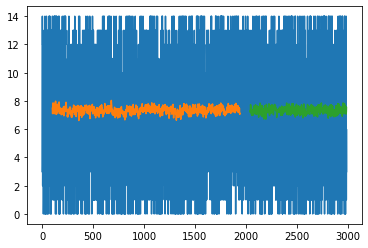

In [20]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
print(len(test_data))

1047


In [22]:
x_input=test_data[946:].reshape(1,-1)
x_input.shape

(1, 101)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.2857142857142857,
 0.7142857142857142,
 0.9285714285714285,
 0.7857142857142857,
 0.8571428571428571,
 0.14285714285714285,
 0.42857142857142855,
 0.07142857142857142,
 0.7857142857142857,
 0.9285714285714285,
 0.5714285714285714,
 0.9285714285714285,
 0.3571428571428571,
 0.0,
 0.0,
 0.9285714285714285,
 0.42857142857142855,
 1.0,
 1.0,
 0.6428571428571428,
 0.9285714285714285,
 0.42857142857142855,
 0.5714285714285714,
 0.42857142857142855,
 0.42857142857142855,
 0.14285714285714285,
 0.6428571428571428,
 0.21428571428571427,
 0.21428571428571427,
 0.07142857142857142,
 1.0,
 0.3571428571428571,
 0.7142857142857142,
 0.6428571428571428,
 0.5714285714285714,
 0.5714285714285714,
 0.0,
 1.0,
 0.5,
 0.07142857142857142,
 1.0,
 0.0,
 0.07142857142857142,
 0.7857142857142857,
 0.5,
 0.3571428571428571,
 0.9285714285714285,
 0.3571428571428571,
 0.7142857142857142,
 0.5,
 0.07142857142857142,
 0.7857142857142857,
 0.0,
 0.5,
 0.2857142857142857,
 0.8571428571428571,
 1.0,
 1.0,
 0.78571

In [24]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [25]:
print(lst_output)
len(lst_output)

[[0.5483627915382385], [0.5402262806892395], [0.5317797660827637], [0.5265428423881531], [0.5242366194725037], [0.5236937999725342], [0.5239683389663696], [0.5245155096054077], [0.5250853896141052], [0.5255904793739319], [0.5260149240493774], [0.5263687968254089], [0.5266665816307068], [0.526921272277832], [0.527142345905304], [0.5273362994194031], [0.5275079607963562], [0.5276604294776917], [0.5277960300445557], [0.527916669845581], [0.5280241966247559], [0.5281196236610413], [0.5282043218612671], [0.5282794833183289], [0.5283457636833191], [0.5284041166305542], [0.5284555554389954], [0.5285007953643799], [0.528540313243866], [0.5285748839378357], [0.5286051034927368], [0.5286315083503723], [0.5286542773246765], [0.5286741256713867], [0.5286914110183716], [0.5287062525749207], [0.5287190675735474], [0.5287302136421204], [0.5287398099899292], [0.5287479758262634], [0.5287550687789917], [0.5287611484527588], [0.5287663340568542], [0.5287708044052124], [0.528774619102478], [0.52877783775

90

In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,191)

In [27]:
import matplotlib.pyplot as plt
len(df1)

2990

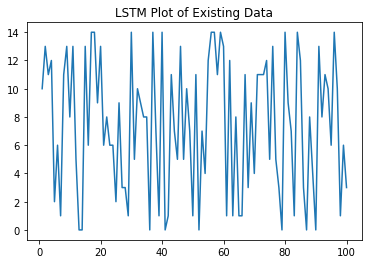

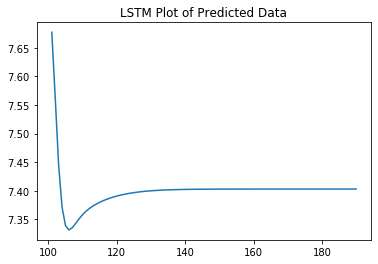

In [28]:
plt.plot(day_new,scaler.inverse_transform(df1[2890:]))
plt.title('LSTM Plot of Existing Data')
plt.show()
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.title('LSTM Plot of Predicted Data')
plt.show()